<ipython-input-1-c6c5f06bd1f0>:28: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  names, varargs, keywords, defaults = inspect.getargspec(func)


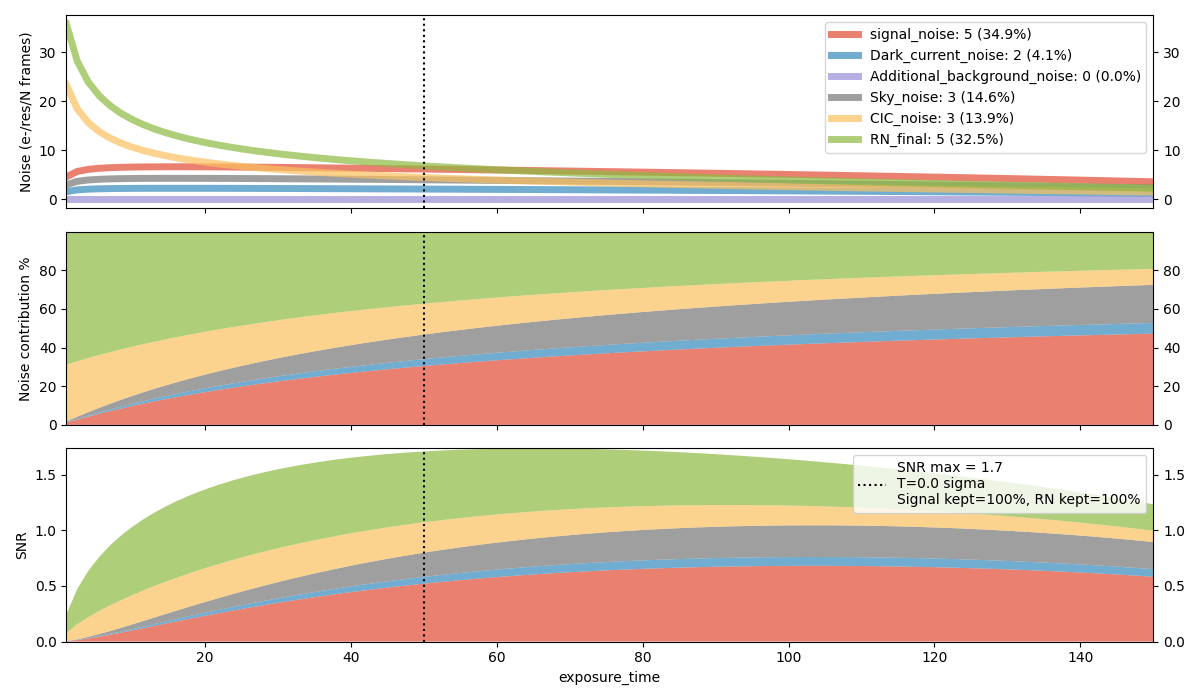

In [1]:
from ipywidgets import Button, Layout, jslink, IntText, IntSlider, interactive, interact, HBox, Layout, VBox
%matplotlib widget
from IPython.display import display, clear_output

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import inspect

import numpy as np
import matplotlib.pyplot as plt
from functools import wraps
import inspect
from scipy.sparse import dia_matrix
# plt.style.use('dark_background')
def initializer(func):
    """
    Automatically assigns the parameters.

    >>> class process:
    ...     @initializer
    ...     def __init__(self, cmd, reachable=False, user='root'):
    ...         pass
    >>> p = process('halt', True)
    >>> p.cmd, p.reachable, p.user
    ('halt', True, 'root')
    """
    names, varargs, keywords, defaults = inspect.getargspec(func)

    @wraps(func)
    def wrapper(self, *args, **kargs):
        for name, arg in list(zip(names[1:], args)) + list(kargs.items()):
            setattr(self, name, arg)

        for name, default in zip(reversed(names), reversed(defaults)):
            if not hasattr(self, name):
                setattr(self, name, default)

        func(self, *args, **kargs)

    return wrapper

#fixed parameters
QE = 0.55
resolution_element=57#microns
pixel_size = 13#microns
#Gain_ADU = 0.53 #e-/e-
Throughput = 0.13
Atmosphere = 0.5
colors = ['#E24A33','#348ABD','#988ED5','#777777','#FBC15E','#8EBA42','#FFB5B8']

def variable_smearing_kernels(image, Smearing=1.5, SmearExpDecrement=50000):
    """Creates variable smearing kernels for inversion
    """
    import numpy as np
    
    smearing_length = Smearing * np.exp(-image / SmearExpDecrement)
    smearing_kernels = np.exp(-np.arange(6)[:, np.newaxis, np.newaxis] / smearing_length)
    smearing_kernels /= smearing_kernels.sum(axis=0)
    return smearing_kernels   


class Observation:
    @initializer
    def __init__(self, exposure_time=50, counting_mode=False, Signal=1.25E-17, EM_gain=1400, RN=109, CIC_charge=0.005, Dard_current=0.08, Sky_LU=10000, readout_time=1.5, flight_background_damping = 0.9, Additional_background_2018 = 0,acquisition_time = 2,smearing=0,i=0,plot_=False):#,photon_kept=0.7
        self.ENF = 2 if counting_mode else 1
        self.CIC_noise = np.sqrt(CIC_charge) if counting_mode else np.sqrt(CIC_charge*2)
        self.Dark_current_f = Dard_current * exposure_time / 3600 # e/pix/frame
        self.Dark_current_noise =  np.sqrt(self.Dark_current_f) if counting_mode else np.sqrt(self.Dark_current_f*2)
        
        self.lu2ergs = 2.33E-19/1000        
        self.Sky_ = Sky_LU*self.lu2ergs#/1000*2.33E-19 # ergs/cm2/s/arcsec^2 
        
        if counting_mode:
            #for now we put the regular QE without taking into account the photon fraciton, because then infinite loop
            self.factor_el = QE * Throughput * Atmosphere*(1.1*np.pi/180/3600)**2*np.pi*100**2/4
            self.sky = Sky_LU*self.factor_el*exposure_time  # el/pix/frame
            self.Sky_f =  self.sky * EM_gain #* Gain_ADU  # el/pix/frame
            self.Sky_noise_pre_thresholding = np.sqrt(self.sky) if counting_mode else np.sqrt(self.sky*2)
            #self.Signal_LU = Signal / self.lu2ergs# LU(self.Sky_/self.Sky_LU)#ergs/cm2/s/arcsec^2 
            #self.Signal_el = self.Signal_LU*self.factor_el*exposure_time 

            #             self.Photon_count_loss = 0.7 if readout_time==1.5 else 0.8 #a contraindre...
            self.n_threshold, self.Photon_fraction_kept, self.RN_fraction_kept,snr_max = self.compute_optimal_threshold(plot_=plot_, i=i) #photon_kept
        else:
            self.n_threshold, self.Photon_fraction_kept, self.RN_fraction_kept = 0,1,1

        self.cosmic_ray_loss = np.minimum(0.005*(exposure_time+readout_time/2),1)
        self.QE_efficiency = self.Photon_fraction_kept * QE#* (1-cosmic_ray_loss)#ne devrait pas etre la 
        
        #for now we put the regular QE without taking into account the photon fraciton, because then infinite loop
        self.factor_el = self.QE_efficiency * Throughput * Atmosphere*(1.1*np.pi/180/3600)**2*np.pi*100**2/4
        self.sky = Sky_LU*self.factor_el*exposure_time  # el/pix/frame
        self.Sky_f =  self.sky * EM_gain #* Gain_ADU  # el/pix/frame
        self.Sky_noise = np.sqrt(self.sky) if counting_mode else np.sqrt(self.sky*2)
            

        #self.RN_fraction_kept = 0.05 if counting_mode else 1
        self.RN_final = RN  * self.RN_fraction_kept / EM_gain #Are we sure about that? we should a
 

        self.Additional_background = Additional_background_2018 * exposure_time *(1-flight_background_damping) # e/pix/f
        self.Additional_background_noise = np.sqrt(self.Additional_background) if counting_mode else np.sqrt(self.Additional_background*2)




        
        
        self.N_images = acquisition_time*3600/(exposure_time+readout_time)
        coeff_stack = 1 #TBC, why was it set to 2
        self.N_images_true = self.N_images * coeff_stack * (1-self.cosmic_ray_loss)
        self.Total_sky = self.N_images_true * self.sky
        self.sky_resolution = self.Total_sky * (resolution_element/pixel_size)**2# el/N exposure/resol
        self.Signal_LU = Signal / self.lu2ergs# LU(self.Sky_/self.Sky_LU)#ergs/cm2/s/arcsec^2 
        self.Signal_el = self.Signal_LU*self.factor_el*exposure_time  # el/pix/frame#     Signal * (sky / Sky_)  #el/pix
        # print(Signal )
        # print(self.Signal_LU )
        # print(self.Signal_el )
#         if counting_mode:
#             print('%0.1f < ExpTime < %0.1f' %(0.01/self.factor_el/self.Signal_LU,0.1/self.factor_el/self.Signal_LU))
    
        self.Signal_resolution = self.Signal_el *self.N_images_true* (resolution_element/pixel_size)**2# el/N exposure/resol
        self.eresolnframe2lu = self.Signal_LU/self.Signal_resolution
        self.signal_noise = np.sqrt(self.Signal_el) if counting_mode else np.sqrt(self.Signal_el*2)     #el / resol/ N frame
        self.signal_noise_resol = self.signal_noise *resolution_element/pixel_size   # el/resol/frame
        self.signal_noise_nframe = self.signal_noise *np.sqrt(self.N_images_true)  # el/resol/frame
        self.Total_noise_final = np.sqrt(self.signal_noise**2 + self.Dark_current_noise**2  + self.Additional_background_noise**2 + self.Sky_noise**2 + self.CIC_noise**2 + self.RN_final**2   ) #e/  pix/frame
        self.factor = np.sqrt(self.N_images_true) * (resolution_element/pixel_size)
        self.Total_noise_nframe = self.Total_noise_final * np.sqrt(self.N_images_true)
        self.Total_noise_resol = self.Total_noise_nframe * (resolution_element/pixel_size)
        self.SNR = self.Signal_resolution/self.Total_noise_resol
        self.Total_noise_final = self.factor*np.sqrt(self.signal_noise**2 + self.Dark_current_noise**2  + self.Additional_background_noise**2 + self.Sky_noise**2 + self.CIC_noise**2 + self.RN_final**2   ) #e/  pix/frame
        if type(self.Total_noise_final + self.Signal_resolution) == np.float64:#to correct
            n=0
        else:
            n =len(self.Total_noise_final + self.Signal_resolution) 
        if n>1:
            for name in ["signal_noise","Dark_current_noise", "Additional_background_noise","Sky_noise", "CIC_noise", "RN_final","Signal_resolution"]:
                setattr(self, name, getattr(self,name)*np.ones(n))
        self.noises = np.array([self.signal_noise*self.factor,  self.Dark_current_noise*self.factor,  self.Additional_background_noise*self.factor, self.Sky_noise*self.factor, self.CIC_noise*self.factor, self.RN_final*self.factor, self.Signal_resolution]).T

        self.snrs=self.Signal_resolution /self.Total_noise_final
        self.percents =  100* np.array(self.noises).T[:-1,:]**2/self.Total_noise_final**2
        # self.percents =  100* np.array(self.noises).T**2/self.Total_noise_final**2

       

    def PlotNoise(self,title='',x='exposure_time'):
        # plt.style.use('seaborn')
        lw=5
        fig, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize=(12, 7), sharex=True)
        for i,(name,c) in enumerate(zip(["signal_noise","Dark_current_noise", "Additional_background_noise","Sky_noise", "CIC_noise", "RN_final"],colors)):
            ax1.plot(getattr(self,x), getattr(self,name)*self.factor,label='%s: %i (%0.1f%%)'%(name,(getattr(self,name)*self.factor)[np.argmax(self.snrs)],self.percents[i,np.argmax(self.snrs)]),lw=lw,alpha=0.7,c=c)
        # ax1.plot(getattr(self,x), getattr(self,"Total_noise_final")*self.factor,label="Total_noise_final", lw=lw,alpha=0.7,c='k')
        ax1.legend(loc='upper right')
        # ax3.plot([getattr(self,x)[np.argmax(self.snrs)],getattr(self,x)[np.argmax(self.snrs)]],[0,np.max(self.snrs)],':',c='k')
        # ax2.plot([getattr(self,x)[np.argmax(self.snrs)],getattr(self,x)[np.argmax(self.snrs)]],[0,100],':',c='k')
        # ax3.plot(getattr(self,x), self.snrs,lw=0,c='k',label='$SNR_{max}$=%0.1f at t=%i'%(np.max(self.snrs),getattr(self,x)[np.argmax(self.snrs)]))
        # ax3.legend(loc='upper right')
        ax1.grid(False)
#         ax1.set_yscale('log')
        ax2.grid(False)
        ax3.grid(False)
        ax3.stackplot(getattr(self,x), self.snrs * np.array(self.noises).T[:-1,:]**2/self.Total_noise_final**2,alpha=0.7,colors=colors)
        ax2.stackplot(getattr(self,x),self.percents,alpha=0.7,colors=colors)
        # stackplot(time,  np.array(self.noises)[:,-1]**2 /np.array(self.noises).T[:1,:]**2)
        ax2.set_xlim((getattr(self,x).min(),getattr(self,x).max()))
        ax2.set_ylim((0,99.99))
        ax3.set_ylim((0,np.max(self.SNR)))
        # ax1.set_ylim((time.min(),time.max()))
        ax3.set_xlabel(x)
        ax3.set_ylabel('SNR')
        ax2.set_ylabel('Noise contribution %')
        ax1.set_ylabel('Noise (e-/res/N frames)')
        ax1.tick_params(labelright=True,right=True)
        ax2.tick_params(labelright=True,right=True)
        ax3.tick_params(labelright=True,right=True)
        # ax1.set_title('$t_{aqu}$:%0.1fh,G$_{EM}$:%i, Counting:%s - SNR$_{MAX}$=%0.1f'%(new.acquisition_time,new.EM_gain,new.counting_mode,np.max(new.SNR)),y=1)
        # fig.suptitle('pompo,')
        # ax1.set_title(title+'Flux:%s, $t_{aqu}$:%0.1fh, G$_{EM}$:%i, Counting:%s'%(self.Signal,self.acquisition_time,self.EM_gain,self.counting_mode))
        fig.tight_layout()
        return fig 

    def compute_optimal_threshold(self,flux = 0.1,plot_=False,title='',i=0):
        #how to increase the speed (3h for 10k points) need to redo with changing flux
        #can not really decrease the binning because the % is touchy close to the histogram peak
        #can not really change the top bin range as it is really used for smearing. if not there will be some king of stairs
        #self.Signal_el if np.isscalar(self.Signal_el) else 0.3
        Emgain = self.EM_gain if np.isscalar(self.EM_gain) else self.EM_gain[i]#1000
        RN= self.RN if np.isscalar(self.RN) else self.RN[i]#80
        CIC_noise = self.CIC_noise if np.isscalar(self.CIC_noise) else self.CIC_noise[i]
        dark_noise = self.Dark_current_noise if np.isscalar(self.Dark_current_noise) else self.Dark_current_noise[i]
         
        try:
            Sky_noise = self.Sky_noise_pre_thresholding if np.isscalar(self.Sky_noise_pre_thresholding) else self.Sky_noise_pre_thresholding[i]
        except AttributeError:
            raise AttributeError('You must use counting_mode=True to use compute_optimal_threshold method.')

        size= (int(1e3),int(1e3))
        im = np.random.poisson(flux, size=size)
        values,bins = np.histogram(im,bins=[-0.5,0.5,1.5,2.5])
        ConversionGain=1#/4.5
        bins = np.linspace(-500,10000,400)
        #imaADU = (np.random.gamma(im, Emgain) + np.random.normal(0, RN, size=size))*ConversionGain
        imaADU = np.random.gamma(im, Emgain) *ConversionGain
        if plot_:
            fig, (ax1, ax2) = plt.subplots(2,1,sharex=True,figsize=(9,5))
            val0,_,l0 = ax1.hist(imaADU[im==0],bins=bins,alpha=0.5,log=True,histtype='step',lw=0.5,color='k',label='Before ampl & smearing')
            val1,_,l1 = ax1.hist(imaADU[im==1],bins=bins,alpha=0.5,log=True,histtype='step',lw=0.5,color='k')
            val2,_,l2 = ax1.hist(imaADU[im==2],bins=bins,alpha=0.5,log=True,histtype='step',lw=0.5,color='k')


        if self.smearing > 0:
            # print(SmearExpDecrement)
            smearing_kernels = variable_smearing_kernels(
                imaADU, self.smearing, SmearExpDecrement=5e4
            )
            offsets = np.arange(6)
            A = dia_matrix(
                (smearing_kernels.reshape((6, -1)), offsets),
                shape=(imaADU.size, imaADU.size),
            )

            imaADU = A.dot(imaADU.ravel()).reshape(imaADU.shape)
        # if plot_:
        #    # fig, (ax1, ax2) = plt.subplots(2,1,sharex=True,figsize=(9,5))
        #     val0,_,l0 = ax1.hist(imaADU[im==0],bins=bins,alpha=0.5,label='Total histogram',log=True,histtype='step',lw=0.5,color='k')
        #     val1,_,l1 = ax1.hist(imaADU[im==1],bins=bins,alpha=0.5,label='Total histogram',log=True,histtype='step',lw=0.5,color='k')
        #     val2,_,l2 = ax1.hist(imaADU[im==2],bins=bins,alpha=0.5,label='Total histogram',log=True,histtype='step',lw=0.5,color='k')


        imaADU += np.random.normal(0, RN, size=size)*ConversionGain
        if plot_:
            val0,_,l0 = ax1.hist(imaADU[im==0],bins=bins,alpha=0.5,label='0',log=True)
            val1,_,l1 = ax1.hist(imaADU[im==1],bins=bins,alpha=0.5,label='1',log=True)
            val2,_,l2 = ax1.hist(imaADU[im==2],bins=bins,alpha=0.5,label='2',log=True)
            ax1.hist(imaADU.flatten(),bins=bins,label='Total histogram',log=True,histtype='step',lw=1,color='k')
        else:
            val0,_ = np.histogram(imaADU[im==0],bins=bins)#,alpha=0.5,label='0',log=True)
            val1,_ = np.histogram(imaADU[im==1],bins=bins)#,alpha=0.5,label='1',log=True)
            val2,_ = np.histogram(imaADU[im==2],bins=bins)#,alpha=0.5,label='2',log=True)

        b = (bins[:-1]+bins[1:])/2
        rn_noise = (RN/(Emgain * ConversionGain)) * np.array([np.sum(val0[b>bi]) for bi in b])/np.sum(val0) #/(Emgain*ConversionGain)#/(Emgain*ConversionGain)
        signal12 = flux * np.array([np.sum(val1[b>bi])+np.sum(val2[b>bi]) for bi in b])/(np.sum(val1)+np.sum(val2))
        signal1 = flux * np.array([np.sum(val1[b>bi]) for bi in b])/np.sum(val1)

        pc =  ([np.sum(val1[b>bi])for bi in b]/(np.array([np.sum(val1[b>bi])for bi in b])+np.array([np.sum(val0[b>bi]) for bi in b])))
       # pc =  ([np.sum(val0[b>bi])for bi in b]/(np.array([np.sum(val1[b>bi])for bi in b])+np.array([np.sum(val0[b>bi]) for bi in b])))


        SNR1 = pc*signal1/np.sqrt(signal1+CIC_noise**2+dark_noise**2+Sky_noise**2+np.array(rn_noise)**2)
        SNR12 = pc*signal12/ np.sqrt(signal12+CIC_noise**2+dark_noise**2+Sky_noise**2+np.array(rn_noise)**2)
        threshold = b[np.nanargmax(SNR1)]
        fraction_signal = np.sum(val1[np.nanargmax(SNR1):])/np.sum(val1)
        fraction_rn = np.sum(val0[np.nanargmax(SNR1):])/np.sum(val0)
        if plot_:
            ax2.plot(b,signal1,label='Signal(Signal>T)')
            ax2.plot(b,np.array(rn_noise)**2,label='(RN(RN>T)/EMGAIN)**2')
            ax2.plot(b,pc,label='Fraction(T) of true positive')
            #ax2.plot(b,SNR1/pc,label='SNR without fraction')



            ax2.plot(b,SNR1,label='SNR, frac(N0)=%i%%, frac(N1)=%i%%'%(100*np.sum(val0[np.nanargmax(SNR1):])/np.sum(val0),100*np.sum(val1[np.nanargmax(SNR1):])/np.sum(val1)))

            # ax2.plot(b,SNR1,label='[N1]/[N0] = %0.2f, frac(N1)=%i%%'%(val1[np.nanargmax(SNR1)]/val0[np.nanargmax(SNR1)],100*np.sum(val1[np.nanargmax(SNR1):])/np.sum(val1)))
            # ax2.plot(b,SNR12,label='[N1+N2]/[N0] = %0.2f, frac(N1+N2)=%i%%'%((val1[np.nanargmax(SNR12)]+val2[np.nanargmax(SNR12)])/val0[np.nanargmax(SNR12)],100*np.sum(val1[np.nanargmax(SNR12):]+val2[np.nanargmax(SNR12):])/(np.sum(val1)+np.sum(val2))))

            L = ax1.legend()
            ax2.legend()
            ax2.set_xlabel('ADU')
            ax1.set_ylabel('#')
            ax2.set_ylabel('SNR')
            threshold = b[np.nanargmax(SNR1)]
            L.get_texts()[1].set_text('0 e- : %i%%, faction kept: %0.2f%%'%(100*values[0]/(size[0]*size[1]),100*np.sum(val0[np.nanargmax(SNR1):])/np.sum(val0)))
            L.get_texts()[2].set_text('1 e- : %i%%, faction kept: %0.2f%%'%(100*values[1]/(size[0]*size[1]),100*np.sum(val1[np.nanargmax(SNR1):])/np.sum(val1)))
            L.get_texts()[3].set_text('2 e- : %i%%, faction kept: %0.2f%%'%(100*values[2]/(size[0]*size[1]),100*np.sum(val2[np.nanargmax(SNR1):])/np.sum(val2)))
            ax1.plot([threshold,threshold],[0,np.max(val0)],':',c='k')
            ax2.plot([threshold,threshold],[0,np.nanmax(SNR1)],':',c='k')
            ax1.set_title(title+'Gain = %i, RN = %i, flux = %0.2f, Smearing=%0.1f, Threshold = %i = %0.2f$\sigma$'%(Emgain,RN,flux,self.smearing, threshold,threshold/(RN*ConversionGain)))
            ax1.set_xlim(xmin=bins.min(),xmax=7000)
            fig.tight_layout()

        #print(i)
        #print('flux, threshold,fractions = ',flux,threshold, fraction_signal, fraction_rn)
        #print('RN, Sky_noise, Emgain, CIC_noise: ', RN, Sky_noise, Emgain, CIC_noise)
        return threshold/(RN*ConversionGain), fraction_signal, fraction_rn, np.nanmax(SNR1)
 



    

np.seterr(invalid='ignore')
class ExposureTimeCalulator(widgets.HBox):
     
    def __init__(self, exposure_time=50, acquisition_time=2, Sky_LU=4, Signal=5.57e-18, EM_gain=1400,RN=109,CIC_charge=0.005, Dard_current=0.08,readout_time=1.5,x_axis='exposure_time',counting_mode=False,smearing=0.7,Additional_background_2018=0):
        super().__init__()
        self.output = widgets.Output()
        self.Additional_background_2018=Additional_background_2018
        Nominal = Observation(exposure_time=np.linspace(1,150,100),counting_mode=counting_mode, Signal=Signal, EM_gain=EM_gain, RN=RN, CIC_charge=CIC_charge, Dard_current=Dard_current, Sky_LU=10**Sky_LU, readout_time=readout_time, acquisition_time = acquisition_time,Additional_background_2018=self.Additional_background_2018,smearing=smearing)#,photon_kept=photon_kept
        #flight_background_damping = 0.9, Additional_background_2018 = 0.0007
        self.x = Nominal.exposure_time#np.linspace(0, 2 * np.pi, 100)
        self.fig  = Nominal.PlotNoise()
        args, _, _, locals_ = inspect.getargvalues(inspect.currentframe())
        self.v=[]
        for i, ax in enumerate(self.fig.axes):
            if i==2:
                
                label = 'SNR max = %0.1f\nT=%0.1f sigma\nSignal kept=%i%%, RN kept=%i%%'%(Nominal.SNR.max(),Nominal.n_threshold, 100*Nominal.Photon_fraction_kept, 100*Nominal.RN_fraction_kept)
                self.v.append(ax.axvline(locals_[x_axis],ls=':',c='k',label=label))
            else:
                self.v.append(ax.axvline(locals_[x_axis],ls=':',c='k'))
        ax.legend(loc='upper right')
        self.ax0 =  self.fig.axes[0]
        self.ax1 =  self.fig.axes[1]
        self.ax2 =  self.fig.axes[2]
    
        self.fig.canvas.toolbar_position = 'bottom'
        style={}#{'description_width': 'initial'} 
        width = '400px'
        self.exposure_time = widgets.IntSlider( min=1, max=150,value=exposure_time, layout=Layout(width=width),description='Texp (s)')#'$t_{exp}$ (s)')
        self.acquisition_time = widgets.FloatSlider( min=0.1, max=10,value=acquisition_time, layout=Layout(width=width),description='Taq (h)')#'$t_{aq}$ (h)')
        self.Sky_LU = widgets.FloatLogSlider( min=4, max=7,value=Sky_LU,base=10, style =style, layout=Layout(width=width),description='Sky (LU)')
#         self.Signal = widgets. FloatLogSlider( min=-18, max=-15,value=1.25e-17, base=10,step=1e-18, style = style, layout=Layout(width='500px'),description='Flux')
        self.Signal = widgets.Dropdown(options=[('Bright Galex star (mU~15)', 2.22e-14), ('Extremely Bright QSO (mU~15)', 5.08e-15), ('Bright QSO (mU~19.5)', 3.51e-16),('Bright galaxy (mU~22.5)', 2.22e-17), ('Regular galaxy (mU~24)', 5.57e-18), ('Low SB galaxy (mU~25)', 2.2e-18)],value=Signal,description='Flux')
        self.EM_gain = widgets.IntSlider( min=200, max=2000,value=EM_gain, style = style, layout=Layout(width=width),description='EM gain')
        self.RN = widgets.IntSlider( min=30, max=120,value=RN, style = style, layout=Layout(width=width),description='Read noise')
        self.CIC_charge = widgets.FloatSlider( min=0.003, max=0.05,value=CIC_charge,style = style, layout=Layout(width=width),description='CIC charge',step=0.001,readout_format='.3f')#$_{charge}$
        self.Dard_current = widgets.FloatSlider( min=0.01, max=0.2,value=Dard_current, style = style, layout=Layout(width=width),description='Dard current',step=0.0011,readout_format='.2f')#$_{current}$
        self.readout_time = widgets.FloatSlider( min=1.5, max=20,value=readout_time, style = style, layout=Layout(width=width),description=r'RO time (s)',step=0.1)#$_{time}$
        self.x_axis=widgets.Dropdown(options=['exposure_time','Sky_LU','acquisition_time',"Signal","EM_gain","RN","CIC_charge","Dard_current" ,"readout_time"],value=x_axis,description='X axis')#,"smearing"
#         self.mode=widgets.Dropdown(options=['Flight 2018','Nominal 2022 10MHz','Nominal 2022 100MHz'],value='Nominal 2022 10MHz',description='X axis')
        self.counting_mode = widgets.Checkbox(value=counting_mode,description='Thresholding photon counting',disabled=False)#,indent=False)
        # smearing = widgets.FloatSlider( min=0, max=1.5,value=0.7, layout=Layout(width='500px'),description='CTE not yet',step=0.001)#'$t_{aq}$ (h)') #widgets.Dropdown(options=[0.2,0.7,1.2],value=0.7,description='Smearing (pix)')

        self.smearing = widgets.FloatSlider( min=0, max=2,value=smearing, layout=Layout(width=width),description='Smearing',step=0.01)#'$t_{aq}$ (h)') #widgets.Dropdown(options=[0.2,0.7,1.2],value=0.7,description='Smearing (pix)')      
        self.smearing.layout.visibility = 'hidden'
    


        
        # wids = widgets.interact(self.update,x_axis=x_axis,counting_mode=False,exposure_time=exposure_time,Sky_LU=Sky_LU,acquisition_time=acquisition_time,Signal=Signal,EM_gain=EM_gain,RN=RN, CIC_charge=CIC_charge, Dard_current=Dard_current, readout_time=readout_time)
        wids = widgets.interactive(self.update,x_axis=self.x_axis,smearing=self.smearing,counting_mode=self.counting_mode,exposure_time=self.exposure_time,Sky_LU=self.Sky_LU,acquisition_time=self.acquisition_time,Signal=self.Signal,EM_gain=self.EM_gain,RN=self.RN, CIC_charge=self.CIC_charge, Dard_current=self.Dard_current, readout_time=self.readout_time)
        controls = VBox([HBox([self.x_axis,self.Signal,self.counting_mode]),   HBox([self.Sky_LU,self.EM_gain,self.smearing])     ,  HBox([self.acquisition_time,self.Dard_current,self.CIC_charge]),    HBox([self.exposure_time,self.RN,self.readout_time]) ] )
        display(HBox([self.output,controls]))


        


    def update(self, x_axis,counting_mode,Sky_LU,acquisition_time,Signal,EM_gain,RN,CIC_charge,Dard_current,readout_time,exposure_time,smearing):
        """Draw line in plot"""
        with self.output:
            args, _, _, locals_ = inspect.getargvalues(inspect.currentframe())
#             self.fig.suptitle('pompo,')
            self.ax0.set_title('Gain=%i, Texp=%i, CIC=%0.3f, Dark=%0.3f, RN=%i, Signal=%0.2E, Sky=%0.2E'%(EM_gain,exposure_time,CIC_charge,Dard_current,RN,Signal,Sky_LU),y=0.97)
            value = locals_[x_axis]
            if x_axis == 'exposure_time':
                exposure_time=np.linspace(1,150,100)
            if x_axis == 'Sky_LU':
                Sky_LU=np.logspace(3,7,100)
                
            if x_axis == 'exposure_time':
                exposure_time=np.linspace(1,150)
            if x_axis == 'Signal':
                Signal=np.logspace(-18,-15)
            if x_axis == 'EM_gain':
                EM_gain=np.linspace(200,2000)
            if x_axis == 'acquisition_time':
                acquisition_time=np.linspace(0.1,6)
            if x_axis == 'RN':
                RN=np.linspace(30,120,100)
            elif x_axis == 'CIC_charge':
                CIC_charge=np.linspace( 0.003, 0.05)
            if x_axis == 'Dard_current':
                Dard_current=np.linspace(0.01,0.2)
            if x_axis == 'readout_time':
                readout_time=np.linspace(0, 50)
            if x_axis == 'smearing':
                readout_time=np.linspace(0, 2)

            if (x_axis == 'Sky_LU') | (x_axis == 'Signal'):
                self.ax0.set_xscale('log')
#                 self.ax2.set_yscale('log')
            else:
                self.ax0.set_xscale('linear')
#                 self.ax2.set_yscale('linear')
            if counting_mode:
                self.smearing.layout.visibility = 'visible'
            else:
                self.smearing.layout.visibility = 'hidden'
            args, _, _, locals_ = inspect.getargvalues(inspect.currentframe())
            new_value = locals_[x_axis]
            arg = np.argmin(abs(new_value - value))
            #print('argi = ',value,new_value,arg)
            new = Observation(exposure_time=exposure_time,Sky_LU=Sky_LU, acquisition_time=acquisition_time,counting_mode=counting_mode,Signal=Signal,EM_gain=EM_gain,RN=RN,CIC_charge=CIC_charge,Dard_current=Dard_current,readout_time=readout_time,smearing=smearing,Additional_background_2018=self.Additional_background_2018,i=arg)
            for v in self.v:
                v.set_xdata([value,value])
            # arg = np.argmin(abs(getattr(new,x_axis) - value))
            # print('arg = ',arg)
            label = 'SNRmax=%0.2f, SNR=%0.2f\nT=%0.1f sigma\nSignal kept=%i%%, RN kept=%i%%'%(new.SNR.max(),new.SNR[arg],new.n_threshold, 100*new.Photon_fraction_kept, 100*new.RN_fraction_kept)
            self.v[-1].set_label(label)

            # self.v[-1].set_label('SNRmax=%0.2f, SNR=%0.2f'%(new.SNR.max(),new.SNR[arg]))
            max_,min_=[],[]
            for i,name in enumerate(["signal_noise","Dark_current_noise", "Additional_background_noise","Sky_noise", "CIC_noise", "RN_final"]):
                self.fig.axes[0].lines[i].set_xdata(getattr(new,x_axis))
                self.fig.axes[0].lines[i].set_ydata(getattr(new,name)*new.factor)
                max_.append(np.nanmax(getattr(new,name)*new.factor))
                min_.append(np.nanmin(getattr(new,name)*new.factor))
                self.fig.axes[0].lines[i].set_label('%s: %i (%0.1f%%)'%(name,(getattr(new,name)*new.factor)[np.argmax(new.snrs)],new.percents[i,np.argmax(new.snrs)]))
            self.ax0.set_ylim((-0.5,np.max(max_)))
            self.ax2.legend(loc='upper right')
            self.fig.axes[0].legend(loc='upper right')
            self.fig.axes[1].collections.clear()#cla()#
            self.fig.axes[1].stackplot(getattr(new,x_axis),new.percents,alpha=0.7,colors=colors)
            self.fig.axes[2].collections.clear()#cla()#
            self.fig.axes[2].stackplot(getattr(new,x_axis),new.snrs * np.array(new.noises).T[:-1,:]**2/new.Total_noise_final**2,alpha=0.7,colors=colors)
            # self.fig.axes[0].lines[0].set_ydata(new.SNR)
            # self.fig.axes[2].lines[0].set_ydata(new.SNR)
            # self.line.set_xdata(getattr(new,x_axis))
            # self.line.set_ydata(new.SNR)
            # self.line.set_data(getattr(new,x_axis),new.SNR)
            self.ax2.set_xlabel(x_axis)
            # self.fig.suptitle('$t_{aqu}$:%0.1fh,G$_{EM}$:%i, Counting:%s - SNR$_{MAX}$=%0.1f'%(new.acquisition_time,new.EM_gain,new.counting_mode,np.max(new.SNR)),y=1)
            # self.fig.axes[0].set_title('$t_{aqu}$:%0.1fh,G$_{EM}$:%i, Counting:%s - SNR$_{MAX}$=%0.1f'%(new.acquisition_time,new.EM_gain,new.counting_mode,np.max(new.SNR)),y=1)
            # self.ax2.set_ylim((np.min(new.SNR),1.1*np.max(new.SNR)))
            self.ax2.set_xlim((np.min(getattr(new,x_axis)),np.max(getattr(new,x_axis))))
            self.ax2.set_ylim((0,np.max(getattr(new,'SNR'))))

            
#Nominal = Observation(exposure_time=np.array([50,50]),EM_gain=1000, RN=100,smearing=0.8).compute_optimal_threshold(plot_=True)#1.5)#2022
#Nominal = Observation(exposure_time=np.array([50,50]),EM_gain=1000, RN=50,smearing=0.8).compute_optimal_threshold(plot_=True)#1.5)#2022
ETC = ExposureTimeCalulator(EM_gain=700,RN=107, smearing=0.8,x_axis='exposure_time',counting_mode=False)



            
# #2022 V2 controller  10MHz
#ETC = ExposureTimeCalulator(EM_gain=1700,RN=50,CIC_charge=0.005, Dard_current=0.18,readout_time=15,smearing=0.8,x_axis='exposure_time',counting_mode=False)
# #2022 V2 controller  10MHz
# ETC = ExposureTimeCalulator(EM_gain=1700,RN=107,CIC_charge=0.005, Dard_current=0.18,readout_time=1.5,smearing=0.8,x_axis='RN',counting_mode=True)


###### Observation(exposure_time=np.array([50,50]),EM_gain=2000,RN=50,CIC_charge=0.005, Dard_current=0.18,readout_time=0.8,smearing=0.7,counting_mode=True).plot_optimal_threshold(title='2022, smearing')#1.5)#2022

In [2]:
from tqdm import tqdm
n=5
m=5
gains=np.linspace(800,2500,n)
rons=np.linspace(30,120,n)
fluxes=np.linspace(0.01,1.51,m)
smearings=np.linspace(0,2,n)
#normally I should also make evolve 

threshold2 = np.zeros((len(gains),len(rons),len(fluxes),len(smearings)))
fraction_flux2 = np.zeros((len(gains),len(rons),len(fluxes),len(smearings)))
fraction_gain2 = np.zeros((len(gains),len(rons),len(fluxes),len(smearings)))
snrs_2 = np.zeros((len(gains),len(rons),len(fluxes),len(smearings)))

gi = np.zeros((len(gains),len(rons),len(fluxes),len(smearings)))
ri = np.zeros((len(gains),len(rons),len(fluxes),len(smearings)))
fi = np.zeros((len(gains),len(rons),len(fluxes),len(smearings)))
si = np.zeros((len(gains),len(rons),len(fluxes),len(smearings)))


for i in tqdm(range(len(gains))):
    for j  in tqdm(range(len(rons))):
        for k in range(len(fluxes)):
            for l in range(len(smearings)):
                t,f1,f2,snr = Observation(exposure_time=np.array([50,50]), EM_gain=gains[i], RN=rons[j],smearing=smearings[l],counting_mode=True).compute_optimal_threshold(flux=fluxes[k],plot_=False)#1.5)#2022
                # print(i, gain, ron, flux, smearing,f1)
                threshold2[i,j,k,l] = t
                fraction_flux2[i,j,k,l] = f1
                fraction_gain2[i,j,k,l] = f2    
                snrs_2[i,j,k,l] = snr    

                gi[i,j,k,l] = gains[i]
                ri[i,j,k,l] = rons[j]
                fi[i,j,k,l] = fluxes[k]
                si[i,j,k,l] = smearings[l]

fits.HDUList([fits.PrimaryHDU(threshold2)]).writeto('threshold_5555.fits',overwrite=True)
fits.HDUList([fits.PrimaryHDU(fraction_flux2)]).writeto('fraction_flux_5555.fits',overwrite=True)
fits.HDUList([fits.PrimaryHDU(fraction_gain2)]).writeto('ffraction_rn_5555.fits',overwrite=True)

# print(threshold)
# print(fraction_flux)
# print(fraction_gain)



100%|██████████| 5/5 [05:16<00:00, 63.29s/it]


NameError: name 'fits' is not defined

In [3]:
from astropy.io import fits

fits.HDUList([fits.PrimaryHDU(threshold2)]).writeto('threshold_5555.fits',overwrite=True)
fits.HDUList([fits.PrimaryHDU(fraction_flux2)]).writeto('fraction_flux_5555.fits',overwrite=True)
fits.HDUList([fits.PrimaryHDU(fraction_gain2)]).writeto('ffraction_rn_5555.fits',overwrite=True)
fits.HDUList([fits.PrimaryHDU(snrs_2)]).writeto('snr_max_5555.fits',overwrite=True)
snrs_2



array([[[[0.06227484, 0.04953211, 0.03298071, 0.02525109, 0.02045334],
         [0.57549114, 0.47227411, 0.352022  , 0.29816831, 0.26817432],
         [0.81921198, 0.67449872, 0.53038266, 0.4728331 , 0.44382686],
         [1.00488356, 0.83432097, 0.68453519, 0.6321139 , 0.60813246],
         [1.16155177, 0.97154449, 0.82600107, 0.78170912, 0.76323978]],

        [[0.05797139, 0.04842422, 0.03310605, 0.02490446, 0.01992095],
         [0.55310088, 0.46934503, 0.34991692, 0.29748151, 0.26534164],
         [0.79049756, 0.67101851, 0.52937621, 0.4713724 , 0.44124705],
         [0.97154149, 0.83056729, 0.6824394 , 0.63111768, 0.60585648],
         [1.12846963, 0.96934586, 0.82431859, 0.78095222, 0.7626853 ]],

        [[0.05316825, 0.04674989, 0.03164844, 0.02378945, 0.01924844],
         [0.53288102, 0.465052  , 0.34765825, 0.29474564, 0.26248844],
         [0.7629601 , 0.66449473, 0.52503689, 0.46802498, 0.439765  ],
         [0.94392296, 0.82478294, 0.67838321, 0.62658065, 0.60410575],
  

Analize_thresholding()

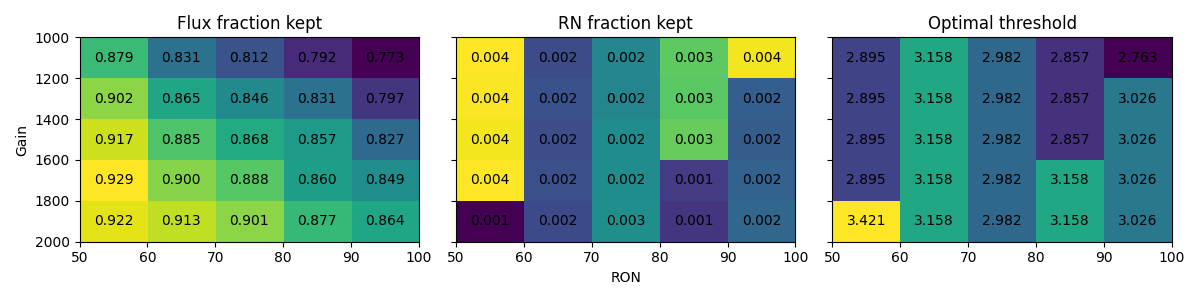

In [280]:
import matplotlib.pyplot as plt
class Analize_thresholding(widgets.HBox):
     
    def __init__(self):
        super().__init__()
        self.output = widgets.Output()
        values = [0,1,2,3]
        values.remove(1)
        values.remove(0)
        i=0
        threshold = fits.open('threshold_5555.fits')[0].data
        fraction_flux = fits.open('fraction_flux_5555.fits')[0].data
        fraction_rn = fits.open('fraction_rn_5555.fits')[0].data
        # popt,pcov = curve_fit(fourDpolynomy_6,(gi.flatten(),ri.flatten(),fi.flatten(),si.flatten()),fraction_flux.flatten())
        # res_fract_flux =  fourDpolynomy_6((gi,ri,fi,si),*popt)
        value=2
        image_threshold = threshold.take(0,axis=value).take(0,axis=value)
        image_fraction_flux = fraction_flux.take(0,axis=value).take(0,axis=value)
        image_fraction_rn = fraction_rn.take(0,axis=value).take(0,axis=value)
        self.options=[('Gain', 0), ('RON',1), ('Flux',2),('Smearing',3)]
        self.names =[['Gain',np.linspace(1000,2000,n)],['RON',np.linspace(50,100,n)], ['Flux',np.linspace(0.1,1,m)],['Smearing',np.linspace(0,1.5,n)]]
        
        x,y=0,1
        self.fig,self.axes  = plt.subplots(1,3,sharey=True,sharex='col',figsize=(12,3))
        for ax,im,title in zip(self.axes.flatten(),[image_fraction_flux,image_fraction_rn,image_threshold],['Flux fraction kept','RN fraction kept','Optimal threshold']):
            # print(i)
            ax.clear()
            ax.imshow(im, extent=[self.names[y][1].min(),self.names[y][1].max(),self.names[x][1].max(),self.names[x][1].min()], aspect="auto")
        # im = ax.imshow(image, extent=[rons.min(),rons.max(),gains.max(),gains.min()], aspect="auto")
        # im = ax.imshow(image, extent=[names[x][1].min(),names[x][1].max(),names[y][1].max(),names[y][1].min()], aspect="auto")
        # im = ax.imshow(image, extent=[names[y][1].min(),names[y][1].max(),names[x][1].max(),names[x][1].min()], aspect="auto")
            ax.set_title(title)

            for xi in range(im.shape[0]):
                for yi in range(im.shape[1]):    
                    ax.text(0.1 + yi/5, 0.1+xi/5, '%0.3f'%(im[-1-xi,yi]), va='center', ha='center',transform=ax.transAxes)   
        self.axes.flatten()[0].set_ylabel(self.names[x][0])
        self.axes.flatten()[1].set_xlabel(self.names[y][0])
        self.fig.tight_layout()
        # self.i_w =  widgets.IntSlider( min=0, max=4,value=0,description='i')
        # self.j_w =  widgets.IntSlider( min=0, max=4,value=0,description='j')
        self.i_w =  widgets.SelectionSlider(options=self.names[values[0]][1],description='Flux',disabled=False,continuous_update=False,orientation='horizontal',readout=True)        
        self.j_w =  widgets.SelectionSlider(options=self.names[values[1]][1],description='Smearing',disabled=False,continuous_update=False,orientation='horizontal',readout=True)        

        self.y_w =  widgets.Dropdown(options=self.options,value=1,description='First axis')
        # options = self.options
        # options.remove((self.y_w.label,self.y_w.index))
        self.x_w =  widgets.Dropdown(options=self.options,value=0,description='Second axis')
        wids = widgets.interactive(self.show_thresholding,i=self.i_w,j=self.j_w,x=self.x_w,y=self.y_w)
        controls = VBox([HBox([self.i_w ,self.y_w  ]),   HBox([ self.j_w,self.x_w ])   ] )
        display(HBox([self.output,controls]))

    def show_thresholding(self,i,j,x,y):
        with self.output:
            values = [0,1,2,3]
            if x==y:
                # print(list(set(values) -set([y])))
                self.x_w.value = list(set(values) -set([y]))[0]
                x=self.x_w.value
            if x>y:
                x,y=y,x
            values.remove(x)
            values.remove(y)
            # image = fraction_flux2.take(i,axis=values[0])#fraction_flux2[]
            i_  = self.i_w.index
            j_  = self.j_w.index
            image_threshold = threshold.take(i_,axis=values[0]).take(j_,axis=values[1]-1)#fraction_flux2[]
            image_fraction_flux = fraction_flux.take(i_,axis=values[0]).take(j_,axis=values[1]-1)#fraction_flux2[]
            image_fraction_rn = fraction_rn.take(i_,axis=values[0]).take(j_,axis=values[1]-1)#fraction_flux2[]
            image_res_fraction_rn = res_fract_flux.take(i_,axis=values[0]).take(j_,axis=values[1]-1)#fraction_flux2[]
            self.i_w.description = self.names[values[0]][0]
            self.j_w.description = self.names[values[1]][0]
            self.i_w.options = self.names[values[0]][1]
            self.j_w.options = self.names[values[1]][1]
            for ax,im,title in zip(self.axes.flatten(),[image_fraction_flux,image_fraction_rn,image_threshold,image_res_fraction_rn],['Flux fraction kept','RN fraction kept','Optimal threshold','Res fract flux']):
                ax.clear()
                ax.imshow(im, extent=[self.names[y][1].min(),self.names[y][1].max(),self.names[x][1].max(),self.names[x][1].min()], aspect="auto")
                ax.set_title(title)
                for xi in range(im.shape[0]):
                    for yi in range(im.shape[1]):    
                        ax.text(0.1 + yi/5, 0.1+xi/5, '%0.3f'%(im[-1-xi,yi]), va='center', ha='center',transform=ax.transAxes)   
            self.axes.flatten()[1].set_xlabel(self.names[y][0])
            self.axes.flatten()[0].set_ylabel(self.names[x][0])

Analize_thresholding()

In [266]:
a= widgets.Dropdown(options=[('Gain', 0), ('RON',1), ('Flux',2),('Smearing',3)],value=0,description='Second axis')

In [270]:
a.label

'Gain'

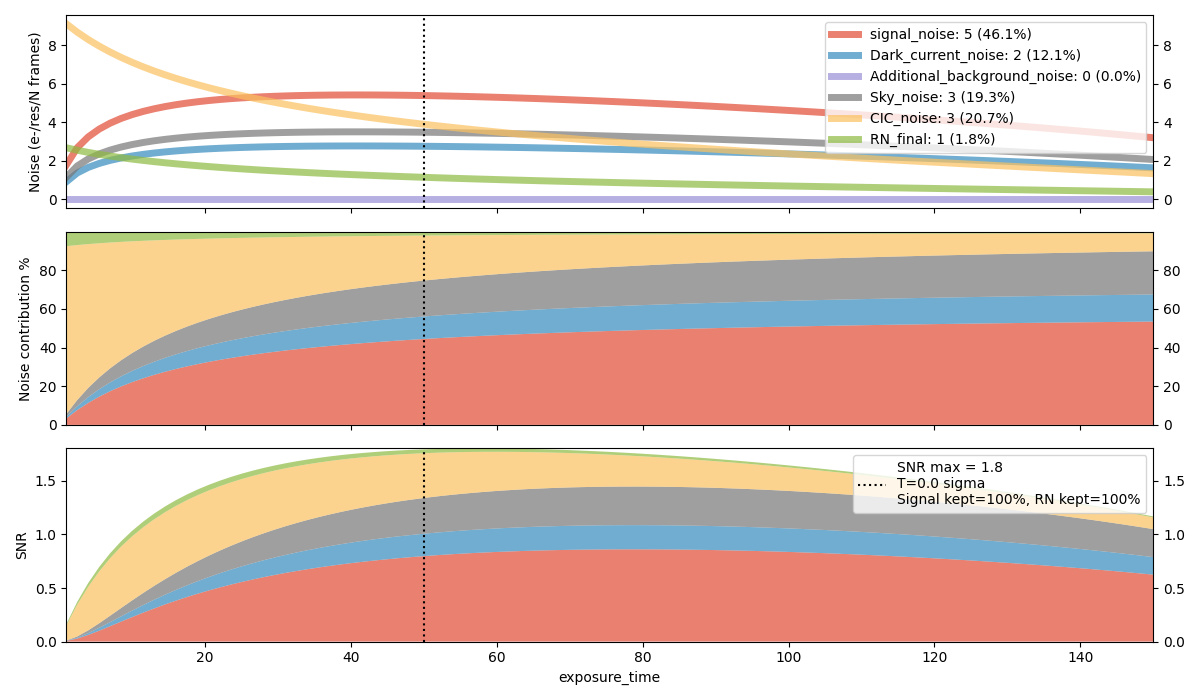

In [2]:
#2022 V3 controller 1MHz
ETC = ExposureTimeCalulator(EM_gain=1700,RN=50,CIC_charge=0.005, Dard_current=0.18,readout_time=15,smearing=0.8)


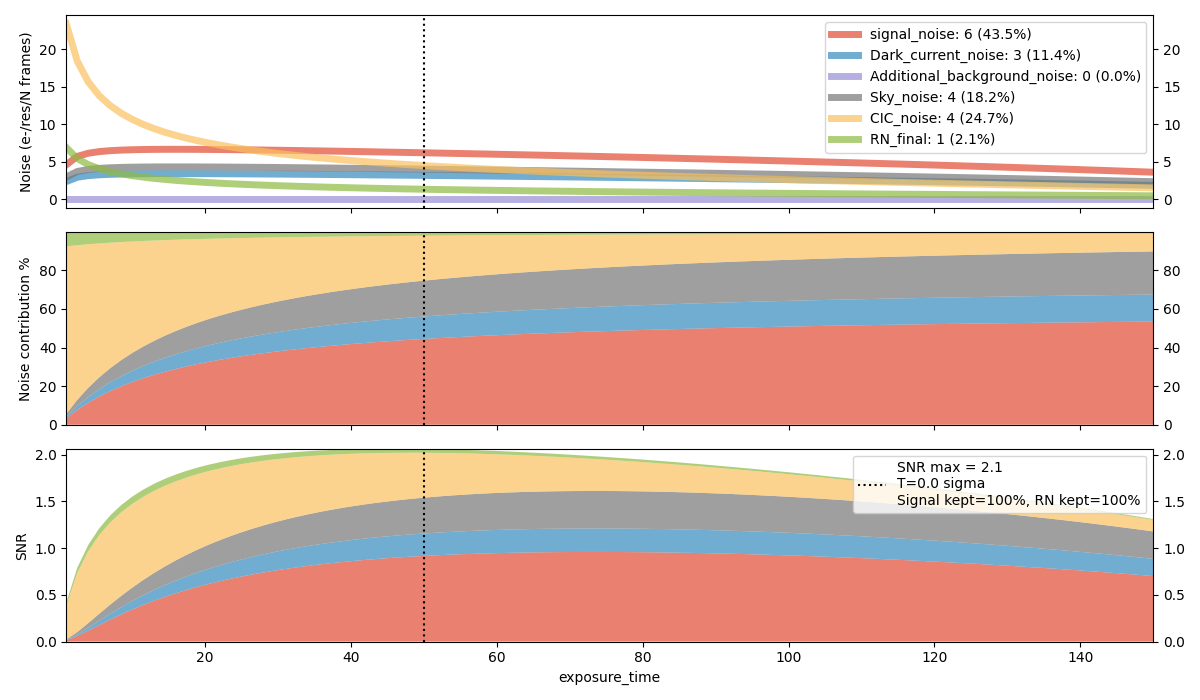

In [3]:
#2022 V2 controller  10MHz
ETC = ExposureTimeCalulator(EM_gain=1700,RN=50,CIC_charge=0.005, Dard_current=0.18,readout_time=1.5,smearing=0.8)


### Conclusions
- At expected sky levels / exposure / dark etc., the noise contributions are Shot noise (55%), CIC (15%), Sky (10%), RN (6%) and Dark current (3%) 
- Therefore, as dark current is the lower noise, it might be work increasing a bit the temperature decrease smearing
- In nominal condditions SNR=5 is obtained with nominal galaxies (continuum), low SB galaxies drop to SNR=1, bright galaxies to 7, QSO to 35 and bright star to SNR=300
- too cold in 2018 (-90 or less)

### Comparison 2018-2022
- 2018: gain=1400,RN=109,CIC=0.005, dark=0.08,ro_time=1.5,photon_kept=0.7
- 2022: gain=1700,RN=50,CIC=0.005, dark=0.18,ro_time=15,photon_kept=0.95
- Not in PC 2018 was better mostly because of a lower dark and time readout
- In PC: better 2022 because of the higher fraction of counts keps (due to lower smearing and RN)


### Questions?
- I think the smearing is not implemented well as it should decrease the high ADU value much more!!! which we see in the histograms weirdly, why not here?
- Are we sure there is no smearing when no amplification?

### TODO
- add smearing
- Add Threshold x*sigma
- Make vary cosmic ray loss fraction with smearing!



In [4]:
np.seterr(divide = 'ignore') 
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)


Nominal = Observation(exposure_time=np.array([5,6]), EM_gain=1400,RN=107).plot_optimal_threshold(title='2018, No smearing')
Nominal = Observation(exposure_time=np.array([5,6]), EM_gain=1400,RN=107).plot_optimal_threshold(Smearing=1.5,title='2018, smearing')
Nominal = Observation(exposure_time=np.array([5,6]), EM_gain=1400/3.2,RN=107).plot_optimal_threshold(title='2018, lower gain no smearing')
#ajouter nombre d'e- recupé pas que %
#SNR: theoreme d'ergodicite (dans plusieurs endroits)
#math sto/an
#ajouter le fond 
#on prend tous les pix superieur au threshold pas que ceux qui ont recu un e-
#choisir le gain 

AttributeError: 'Observation' object has no attribute 'plot_optimal_threshold'


### Conclusions
- Need a quantitative cross check with Bruno's model
- Gain<10*RN decreases the SNR
- Smearing decreases it even more
- Smearing seems to have more impact that just dividind the gain by ~3
- 2022: increased EMgain and decreased RN helps a bit with and without smearing but most important is the fact that new RO frequency could decrease the smearing
- no less than 3-3.5


### Questions/Problems?
- The smearing do not seem to change that much with the addition of smeaering. YES just the smearing was not 0.7 but 1.5
- Impossible that the read noise gets amplified that much with smearing... YES it is possible, it is just that read noise pixels get flux from their neighboors that might have received 2e- and amplified a lot!
- But then the issue is that the highes SNR should not be when e-==0 crosses approx e-==2. Basically the read noise stays the same! This is due to the fact that I sum the log, I should sum 10**log

### TODO
- Comparison with Matematica model




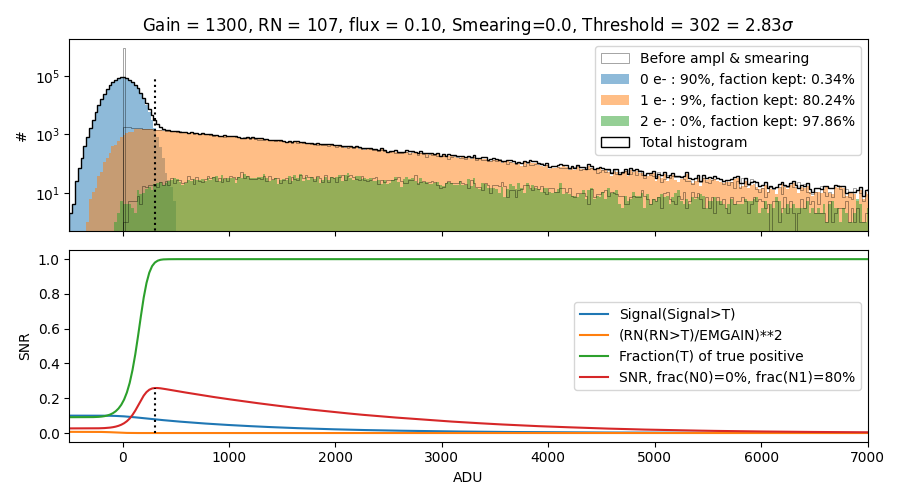

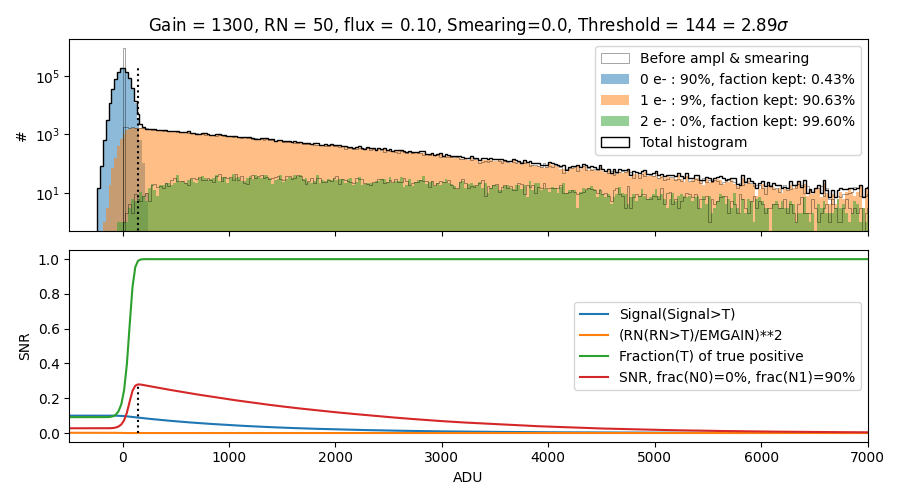

In [173]:
Nominal = Observation(exposure_time=np.array([50,50]),EM_gain=1300, RN=107,smearing=0,counting_mode=True).compute_optimal_threshold(plot_=True)#1.5)#2022
Nominal = Observation(exposure_time=np.array([50,50]),EM_gain=1300, RN=50,smearing=0,counting_mode=True).compute_optimal_threshold(plot_=True)#1.5)#2022
# Nominal = Observation(exposure_time=np.array([5,6]),EM_gain=1700, RN=107).plot_optimal_threshold(Smearing=0.6,title='2022, smearing')#1.5)#2022



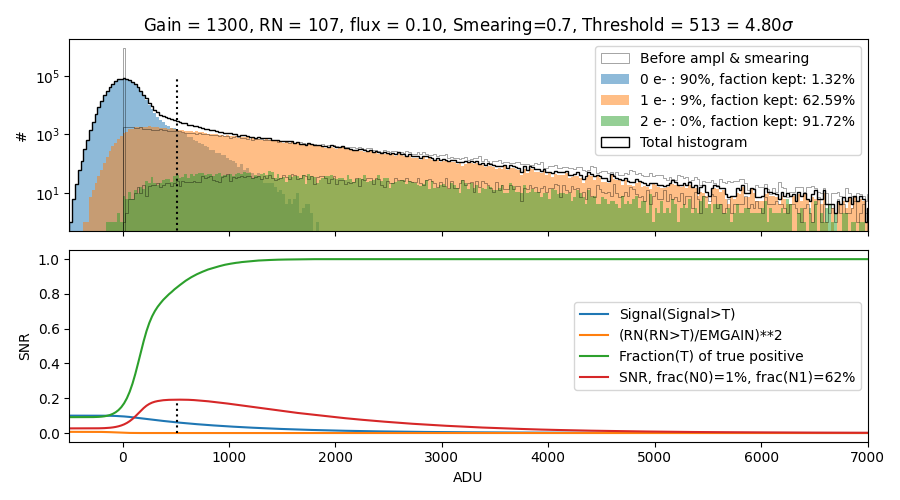

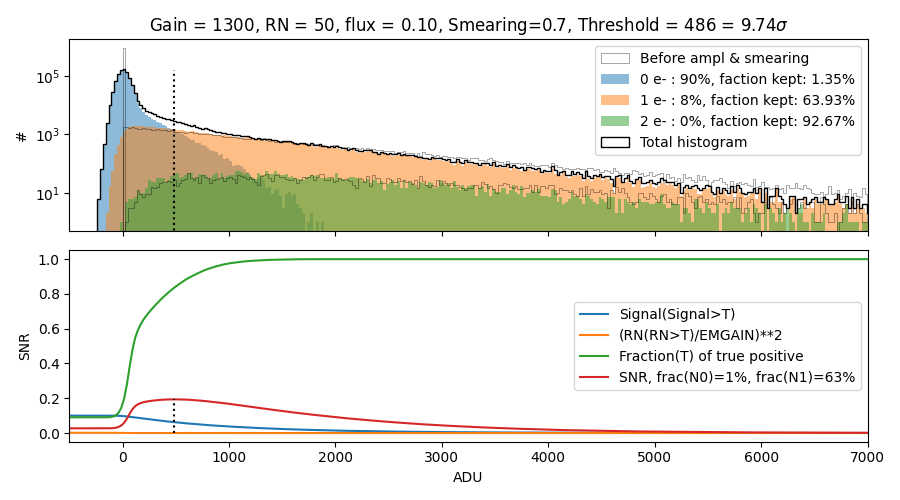

In [177]:
Nominal = Observation(exposure_time=np.array([50,50]),EM_gain=1300, RN=107,smearing=0.7,counting_mode=True).compute_optimal_threshold(plot_=True)#1.5)#2022
Nominal = Observation(exposure_time=np.array([50,50]),EM_gain=1300, RN=50,smearing=0.7,counting_mode=True).compute_optimal_threshold(plot_=True)#1.5)#2022



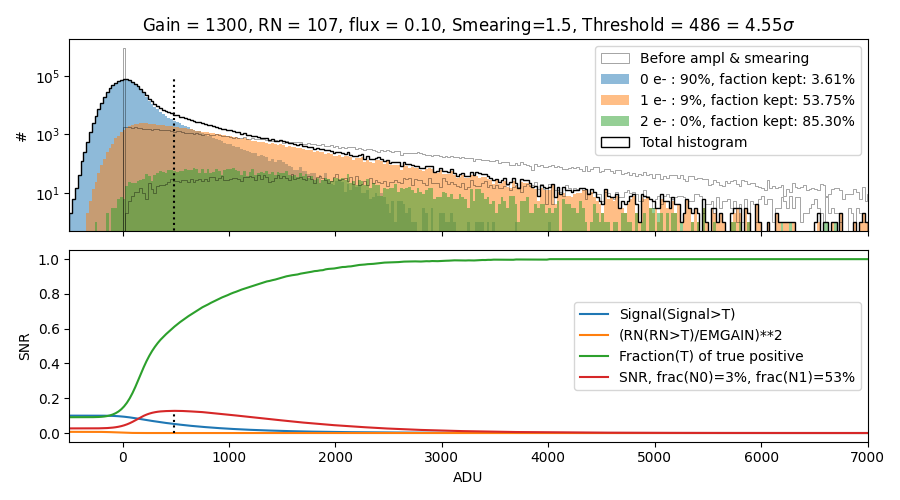

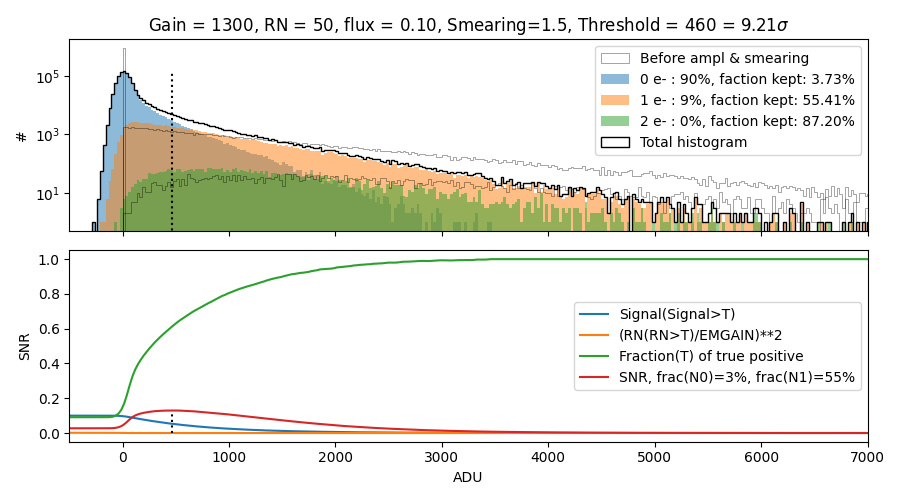

In [175]:
Nominal = Observation(exposure_time=np.array([50,50]),EM_gain=1300, RN=107,smearing=1.5,counting_mode=True).compute_optimal_threshold(plot_=True)#1.5)#2022
Nominal = Observation(exposure_time=np.array([50,50]),EM_gain=1300, RN=50,smearing=1.5,counting_mode=True).compute_optimal_threshold(plot_=True)#1.5)#2022



In [4]:
np.linspace(0.01,1.01,5)

array([0.01, 0.26, 0.51, 0.76, 1.01])

  0%|          | 0/15 [00:00<?, ?it/s]

Text(0.5, 0, 'ron')

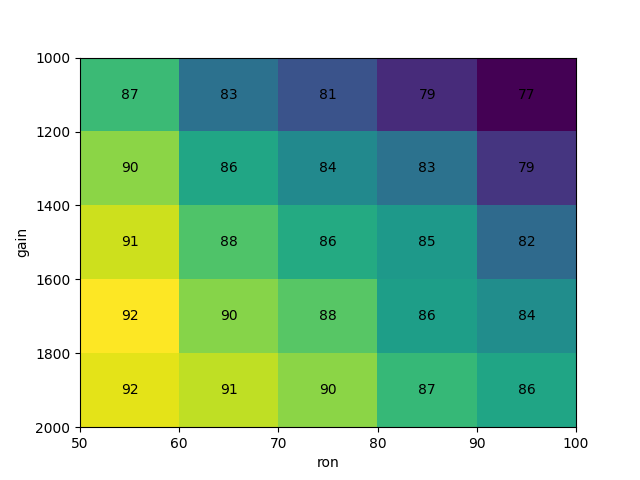

In [131]:
# threshold2.shape
# # from astropy.io import fits
# fits.HDUList([fits.PrimaryHDU(threshold2)]).writeto('threshold_5555.fits',overwrite=True)
# fits.HDUList([fits.PrimaryHDU(fraction_flux2)]).writeto('fraction_flux_5555.fits',overwrite=True)

# fits.HDUList([fits.PrimaryHDU(fraction_gain2)]).writeto('ffraction_rn_5555.fits',overwrite=True)

i=0
fig, ax  = plt.subplots()
im = ax.imshow(fraction_flux2[:,:,i,i], extent=[rons.min(),rons.max(),gains.max(),gains.min()], aspect="auto")
for xi in range(fraction_flux2[:,:,i,i].shape[0]):
    for yi in range(fraction_flux2[:,:,i,i].shape[1]):    
        ax.text(0.1 + yi/5, 0.1+xi/5, '%i'%(100*fraction_flux2[-1-xi,yi,i,i]), va='center', ha='center',transform=ax.transAxes)
ax.set_ylabel('gain')
ax.set_xlabel('ron')
# ax.set_title('No smearing')
# ax.colorbar(im)
# plt.show()
# fraction_flux2

In [216]:
from scipy.optimize import curve_fit
def fourDpolynomy(wxyz,a0,a1,a2,b1,b2,c1,c2,d1,d2):
    w, x, y, z = wxyz
    f=a0
    f+= a1 * w + a2 * w ** 2
    f+= b1 * x + b2 * x ** 2
    f+= c1 * y + c2 * y ** 2
    f+= d1 * z + d2 * z ** 2
    return f

from scipy.optimize import curve_fit
def fourDpolynomy_3(wxyz,a0,a1,a2,a3,b1,b2,b3,c1,c2,c3,d1,d2,d3):
    w, x, y, z = wxyz
    f=a0
    f+= a1 * w + a2 * w ** 2 + a3 * w ** 3
    f+= b1 * x + b2 * x ** 2 + b3 * x ** 3
    f+= c1 * y + c2 * y ** 2 + c3 * y ** 3
    f+= d1 * z + d2 * z ** 2 + d3 * z ** 3
    return f

def fourDpolynomy_4(wxyz,a0,a1,a2,a3,a4,b1,b2,b3,b4,c1,c2,c3,c4,d1,d2,d3,d4):
    w, x, y, z = wxyz
    f=a0
    f+= a1 * w + a2 * w ** 2 + a3 * w ** 3 + a4 * w ** 4
    f+= b1 * x + b2 * x ** 2 + b3 * x ** 3 + b4 * x ** 4
    f+= c1 * y + c2 * y ** 2 + c3 * y ** 3 + c4 * y ** 4
    f+= d1 * z + d2 * z ** 2 + d3 * z ** 3 + d4 * z ** 4
    return f

def fourDpolynomy_5(wxyz,a0,a1,a2,a3,a4,a5,b1,b2,b3,b4,b5,c1,c2,c3,c4,c5,d1,d2,d3,d4,d5):
    w, x, y, z = wxyz
    f=a0
    f+= a1 * w + a2 * w ** 2 + a3 * w ** 3 + a4 * w ** 4  + a5 * w ** 5
    f+= b1 * x + b2 * x ** 2 + b3 * x ** 3 + b4 * x ** 4  + b5 * x ** 5
    f+= c1 * y + c2 * y ** 2 + c3 * y ** 3 + c4 * y ** 4  + c5 * y ** 5
    f+= d1 * z + d2 * z ** 2 + d3 * z ** 3 + d4 * z ** 4  + d5 * z ** 5
    return f

def fourDpolynomy_6(wxyz,a0,a1,a2,a3,a4,a5,a6,b1,b2,b3,b4,b5,b6,c1,c2,c3,c4,c5,c6,d1,d2,d3,d4,d5,d6):
    w, x, y, z = wxyz
    f=a0
    f+= a1 * w + a2 * w ** 2 + a3 * w ** 3 + a4 * w ** 4  + a5 * w ** 5   + a6 * w ** 6
    f+= b1 * x + b2 * x ** 2 + b3 * x ** 3 + b4 * x ** 4  + b5 * x ** 5   + b6 * x ** 6
    f+= c1 * y + c2 * y ** 2 + c3 * y ** 3 + c4 * y ** 4  + c5 * y ** 5   + c6 * y ** 6
    f+= d1 * z + d2 * z ** 2 + d3 * z ** 3 + d4 * z ** 4  + d5 * z ** 5   + d6 * z ** 6
    return f



popt,pcov = curve_fit(fourDpolynomy_3,(gi.flatten(),ri.flatten(),fi.flatten(),si.flatten()),fraction_flux.flatten())
print(popt)

# fourDpolynomy((gi.flatten(),ri.flatten(),fi.flatten(),si.flatten()),*popt)


[ 7.73552834e-01  2.05951248e-04 -1.16724030e-07  2.28117806e-11
 -2.31670233e-03  2.63692746e-05 -1.22353192e-07  1.02054854e-01
  9.16571471e-02 -6.09311275e-02 -2.31915894e-01 -1.03911549e-01
  1.10818248e-01]


interactive(children=(IntSlider(value=0, description='i', max=4), IntSlider(value=0, description='j', max=4), …

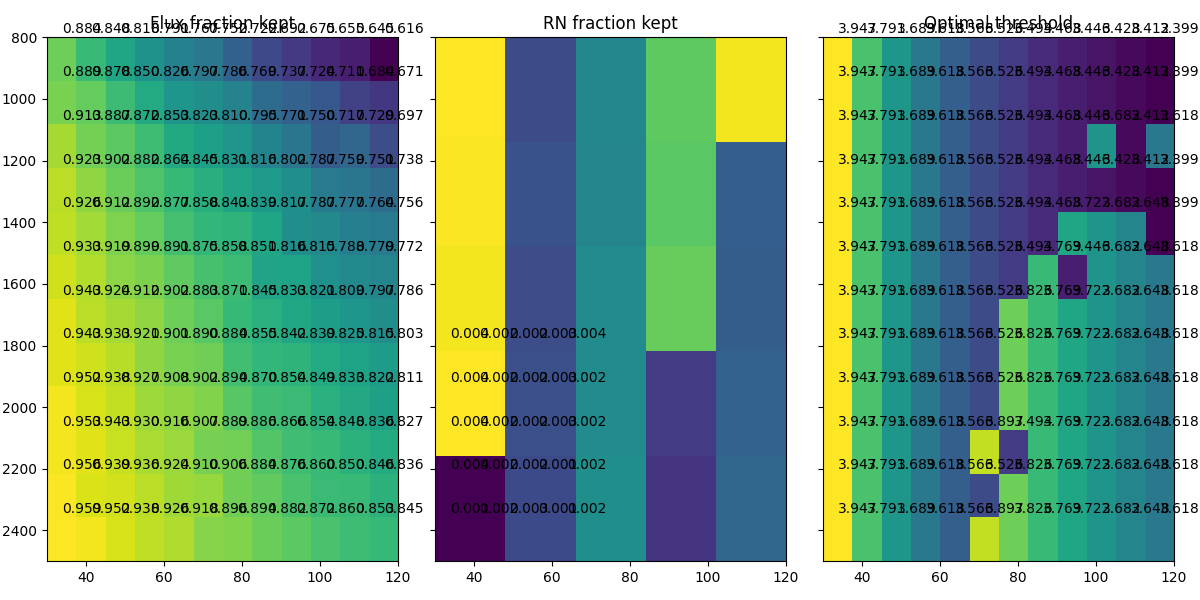

In [11]:
import matplotlib.pyplot as plt

i=0
# fig, ax = plt.subplots()
fig, (ax0,ax1,ax2)  = plt.subplots(1,3,sharey=True,sharex='col',figsize=(12,6))
for ax,title in zip([ax0,ax1,ax2],['Flux fraction kept','RN fraction kept','Optimal threshold']):
    ax.set_title(title)
fig.tight_layout()
# im = ax.imshow(fraction_flux2[:,:,i,i], extent=[rons.min(),rons.max(),gains.max(),gains.min()], aspect="auto")
# for xi in range(fraction_flux2[:,:,i,i].shape[0]):
#     for yi in range(fraction_flux2[:,:,i,i].shape[1]):    
#         ax.text(0.1 + yi/5, 0.1+xi/5, '%i'%(100*fraction_flux2[-1-xi,yi,i,i]), va='center', ha='center',transform=ax.transAxes)
# ax.set_ylabel('gain')
# ax.set_xlabel('ron')
# ax.set_title('No smearing')
# ax.colorbar(im)
# plt.show()
threshold = fits.open('threshold_5555.fits')[0].data
fraction_flux = fits.open('fraction_flux_5555.fits')[0].data
fraction_rn = fits.open('fraction_rn_5555.fits')[0].data


gains=np.linspace(800,2500,n)
rons=np.linspace(30,120,n)
fluxes=np.linspace(0.01,1.51,m)
smearings=np.linspace(0,2,n)

# popt,pcov = curve_fit(fourDpolynomy_6,(gi.flatten(),ri.flatten(),fi.flatten(),si.flatten()),fraction_flux.flatten())
# res_fract_flux =  fourDpolynomy_6((gi,ri,fi,si),*popt)
def show_threshoding(i,j,x,y):
    # i=0
    # fig, ax  = plt.subplots()
    # im = ax.imshow(fraction_flux2[:,:,i,i], extent=[rons.min(),rons.max(),gains.max(),gains.min()], aspect="auto")

    names=[['Gain',gains],['RON',rons], ['Flux',fluxes],['Smearing',smearings]]
    values = [0,1,2,3]
    if x>y:
        x,y=y,x
    values.remove(x)
    values.remove(y)
    # image = fraction_flux2.take(i,axis=values[0])#fraction_flux2[]
    image_threshold = threshold.take(i,axis=values[0]).take(j,axis=values[1]-1)#fraction_flux2[]
    image_fraction_flux = fraction_flux.take(i,axis=values[0]).take(j,axis=values[1]-1)#fraction_flux2[]
    image_fraction_rn = fraction_rn.take(i,axis=values[0]).take(j,axis=values[1]-1)#fraction_flux2[]

    # image_res_fraction_rn = res_fract_flux.take(i,axis=values[0]).take(j,axis=values[1]-1)#fraction_flux2[]

    # image = fraction_flux2.take(i,axis=values[0]).take(j,axis=values[1]-1)#fraction_flux2[]
    # image = fraction_flux2.take(i,axis=values[0]).take(j,axis=values[1]-1)#fraction_flux2[]
    # image = fraction_flux2.take(np.arange(5),axis=)#fraction_flux2[]
    for ax,im,title in zip([ax0,ax1,ax2,ax3],[image_fraction_flux,image_fraction_rn,image_threshold],['Flux fraction kept','RN fraction kept','Optimal threshold','Res fract flux']):
        # print(i)
        ax.clear()
        ax.imshow(im, extent=[names[y][1].min(),names[y][1].max(),names[x][1].max(),names[x][1].min()], aspect="auto")
    # im = ax.imshow(image, extent=[rons.min(),rons.max(),gains.max(),gains.min()], aspect="auto")
    # im = ax.imshow(image, extent=[names[x][1].min(),names[x][1].max(),names[y][1].max(),names[y][1].min()], aspect="auto")
    # im = ax.imshow(image, extent=[names[y][1].min(),names[y][1].max(),names[x][1].max(),names[x][1].min()], aspect="auto")
        ax.set_title(title)

        for xi in range(im.shape[0]):
            for yi in range(im.shape[1]):    
                ax.text(0.1 + yi/n, 0.1+xi/n, '%0.3f'%(im[-1-xi,yi]), va='center', ha='center',transform=ax.transAxes)   
    ax4.set_xlabel(names[y][0])
    ax0.set_ylabel(names[x][0])
    ax3.set_ylabel(names[x][0])




    # im.set_data(fraction_flux2[:,:,i,i])
    # plt.draw()
    # for xi in range(fraction_flux2[:,:,i,i].shape[0]):
    #     for yi in range(fraction_flux2[:,:,i,i].shape[1]):    
    #         ax.text(0.1 + yi/5, 0.1+xi/5, '%i'%(100*fraction_flux2[xi,yi,i,i]), va='center', ha='center',transform=ax.transAxes)
    # ax.set_ylabel('gain')
    # ax.set_xlabel('ron')
    # ax.set_title('No smearing')
    # ax.colorbar(im)
    # plt.show()




i_w =  widgets.IntSlider( min=0, max=4,value=0)#, layout=Layout(width=width))
j_w =  widgets.IntSlider( min=0, max=4,value=0)#, layout=Layout(width=width))
y_w =  widgets.Dropdown(options=[('Gain', 0), ('RON',1), ('Flux',2),('Smearing',3)],value=1,description='First axis')
x_w =  widgets.Dropdown(options=[('Gain', 0), ('RON',1), ('Flux',2),('Smearing',3)],value=0,description='Second axis')




a = interact(show_threshoding, i=i_w, j=j_w,x=x_w,y=y_w)#,SmearExpDecrement=exp)

# plt.figure()
# plt.imshow(np.log10(fraction_flux2[:,i,i,:]))
# plt.ylabel('gain')
# plt.xlabel('smearing')
# plt.title('small ron')
# plt.colorbar()
# plt.show()



# plt.figure()
# plt.imshow(fraction_flux2[:,i,:,i])
# plt.ylabel('gain')
# plt.xlabel('flux')
# plt.title('small ron')
# plt.colorbar()
# plt.show()


# plt.figure()
# plt.imshow(fraction_flux2[i,:,i,:])
# plt.ylabel('ron')
# plt.xlabel('smearing')
# plt.title('small gain')
# plt.colorbar()
# plt.show()

# print(fraction_flux)
# print(fraction_gain)



# Conclusions
- At low smearing the bigger the ratio gain/ron the higher the fraction of charges kept
- Evolution with smearing is dramatic, higher gain does not help much, lower RN help a bit!
- Fraction increase with flux
- We need to remember that as soon as flux fraction kept<1/sqrt(2), then photon counting will not be worthy (of course descmearing might help)

Analize_thresholding()

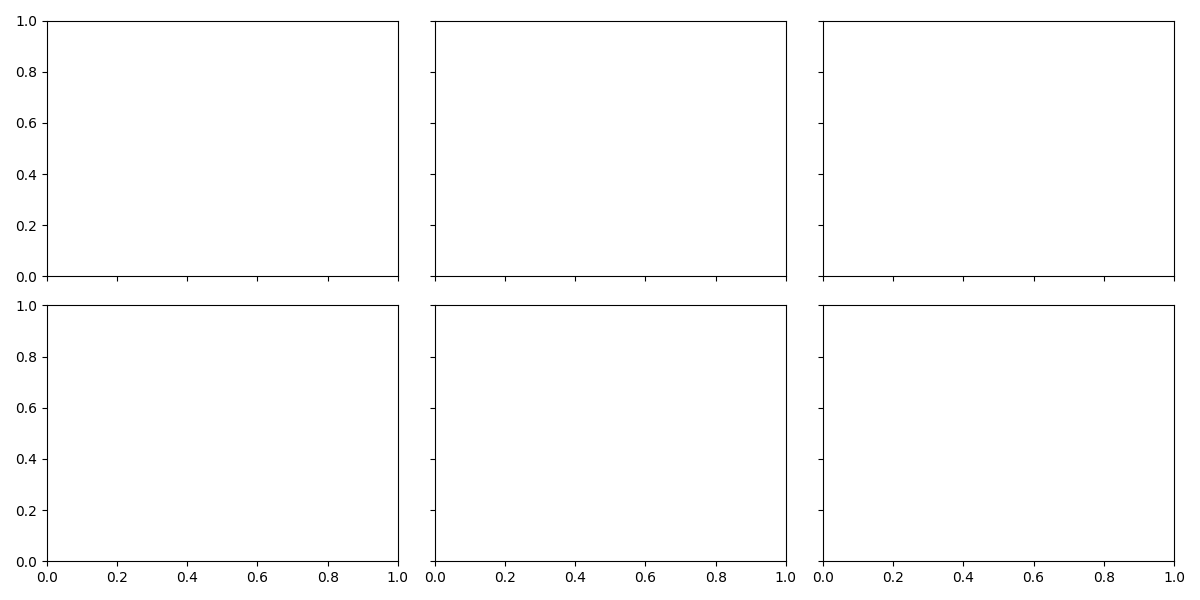

In [155]:
[Observation(exposure_time=np.array([50,50]), EM_gain=1000, RN=f,smearing=f,counting_mode=True).compute_optimal_threshold(flux=0.1,plot_=False)[1] for f in np.linspace(0,1,5)]

<ipython-input-5-4bbf89b4a7e7>:289: RuntimeWarning: divide by zero encountered in double_scalars
  return threshold/(RN*ConversionGain), fraction_signal, fraction_rn


[1.0,
 0.9491810349594665,
 0.7260077621945841,
 0.6483722365491855,
 0.5950900526461623]

In [180]:

# def TakeAverage(x, y, z, weight=None, binsx=50, binsy=50, output="scatter", Plot=False, type_=None):
#     #    data1, a, b, p = plt.hist2d(cat['x'],cat['y'],weights=cat['z'],bins=[bins,bins])
#     #    data2, a, b, p  = plt.hist2d(cat['x'],cat['y'],bins=[bins,bins])
#     data2, a, b = np.histogram2d(x, y, bins=[binsx, binsy])
#     if type_ is not None:
#         #        for i, (xi, yi, zi) in enumerate(zip(x,y,z)):
#         #            verboseprint(xi,yi,zi,i)
#         for i, ai in enumerate(a[:-1]):
#             for j, bj in enumerate(a[:-1]):
#                 # print(i,i,ai,bj)
#                 mask = (x > a[i]) & (x < a[i + 1]) & (y > b[j]) & (y < b[j + 1])
#                 if type_ == "std":
#                     # verboseprint('Choosing std')
#                     z[mask] = np.std(z[mask])
#                 if type_ == "median":
#                     # verboseprint('Choosing median')
#                     z[mask] = np.median(z[mask])
#                 if weight is not None:
#                     z[mask] = np.dot(weight, IRX) / np.sum(weight)

#     data1, a, b = np.histogram2d(x, y, weights=z, bins=[binsx, binsy])

#     if output == "scatter":
#         xm, ym = np.meshgrid(a, b, indexing="ij")
#         if Plot:
#             plt.scatter(xm[:-1, :-1].flatten(), ym[:-1, :-1].flatten(), c=(data1 / data2).flatten())
#             plt.colorbar()
#         return xm[:-1, :-1].flatten(), ym[:-1, :-1].flatten(), (data1 / data2).flatten()
#     if output == "image":
#         if Plot:
#             plt.imshow((data1 / data2)[:, ::-1].T, extent=[a.min(), a.max(), b.min(), b.max()], aspect="auto")
#             plt.colorbar()
#         return (data1 / data2)[:, ::-1].T, a, b




(3.0263157894736836, 0.7515156225711177, 0.001994030061798361)

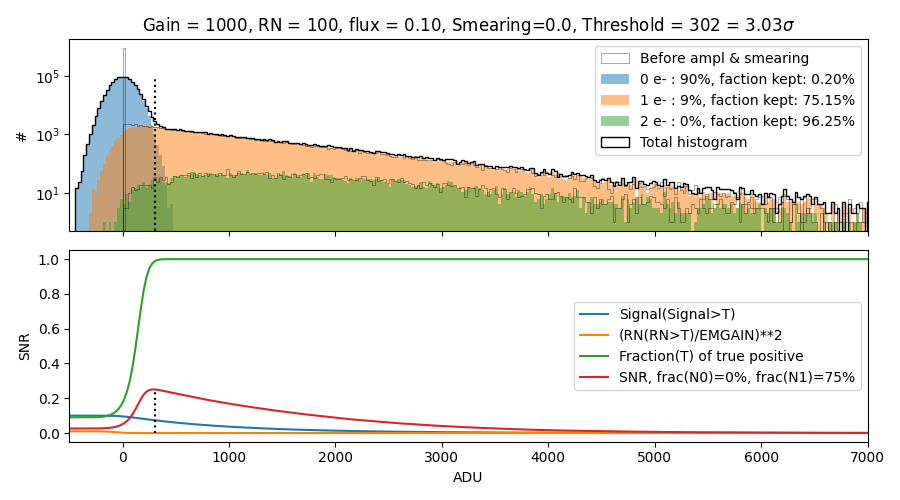

In [33]:
Observation(exposure_time=np.array([50,50]), EM_gain=1000, RN=100,smearing=0,counting_mode=True).compute_optimal_threshold(flux=0.1,plot_=True)#1.5)#2022

(2.8947368421052624, 0.9356754246284501, 0.004168601693978195)

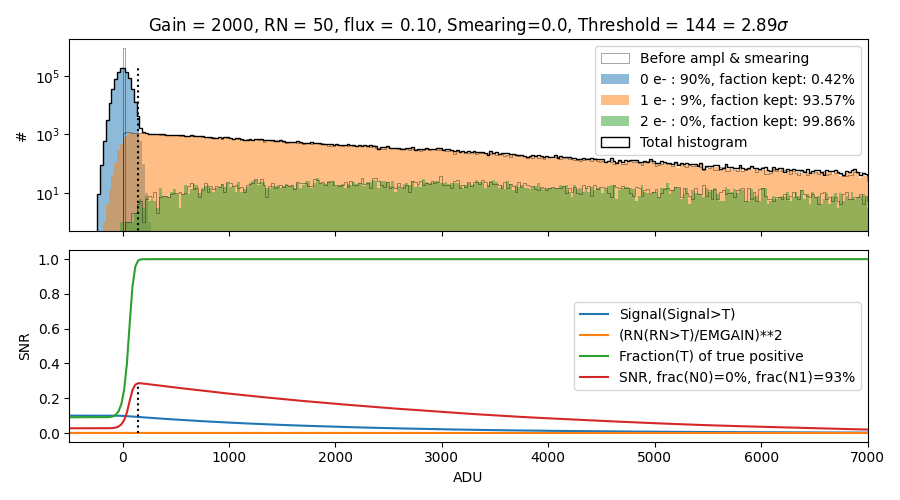

In [34]:
Observation(exposure_time=np.array([50,50]), EM_gain=2000, RN=50,smearing=0,counting_mode=True).compute_optimal_threshold(flux=0.1,plot_=True)#1.5)#2022